# Computer Vision Project : Enhancing Nucleus Segmentation and 3D Reconstruction Using Super-Resolution


## Group Members:
### Rita Sulaiman – Student ID: 2210765051
### Zeynep Yıldız – Student ID: 2210765033
### Zharasbek Bimagambetov – Student ID: 2210356185


### Imports

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


### Preprocessing and Image Display

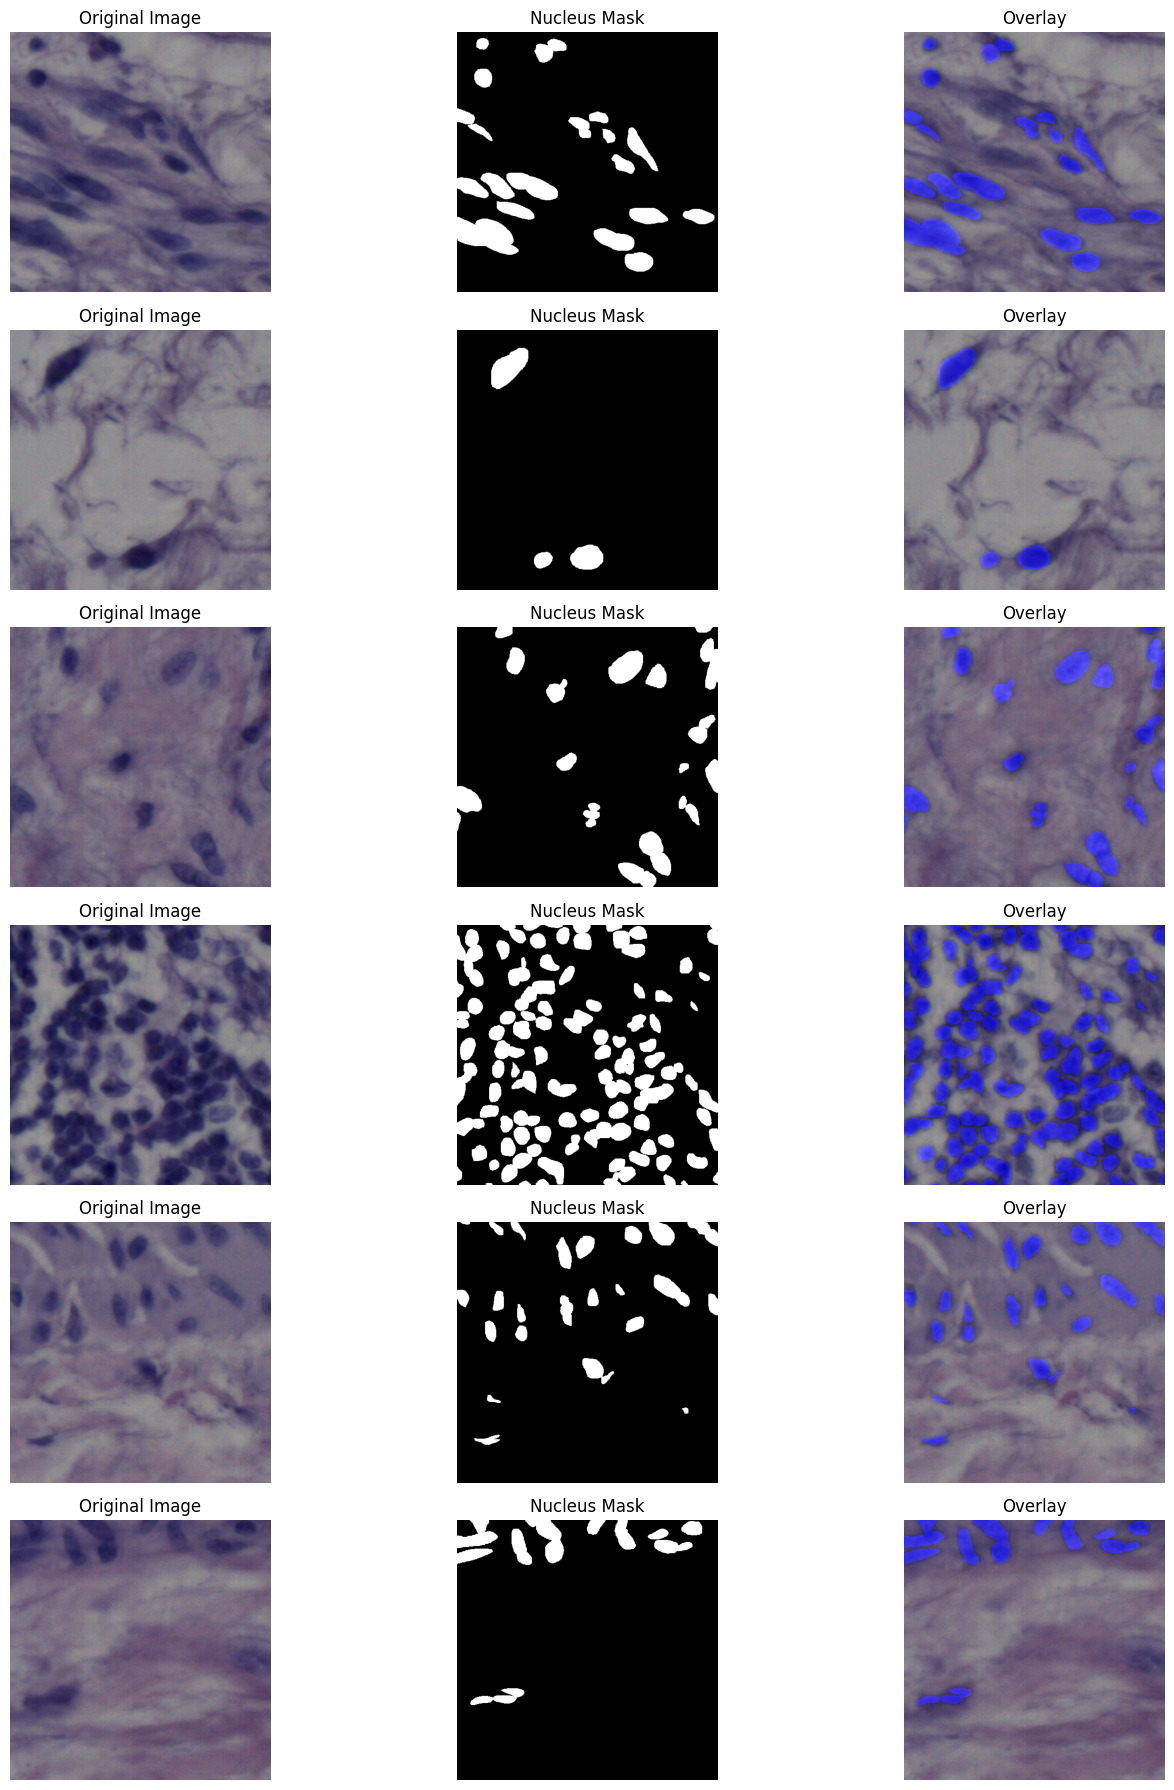

 Preprocessing complete
X shape: (12, 256, 256, 3)
Y shape: (12, 256, 256, 1)


In [2]:
# ================================
#  CONFIGURATION
# ================================

# Set base dataset directory (adjust if needed)
BASE_DIR = "."  # or use full path if notebook is outside the dataset folder
IMAGE_DIR = os.path.join(BASE_DIR, "tissue images")
MASK_DIR = os.path.join(BASE_DIR, "mask binary")  # or "label masks"

# Image size for model input
TARGET_SIZE = (256, 256)

# ================================
#  PREPROCESSING FUNCTIONS
# ================================

def preprocess_image(image, target_size):
    image = cv2.resize(image, target_size)
    image = image.astype(np.float32) / 255.0
    return image

def preprocess_mask(mask, target_size):
    mask = cv2.resize(mask, target_size)
    mask = (mask > 127).astype(np.float32)  # binary 0 and 1
    mask = np.expand_dims(mask, axis=-1)    # Shape: (H, W, 1)
    return mask


# ================================
#  LOAD, DISPLAY, AND PREPROCESS
# ================================

image_files = sorted(os.listdir(IMAGE_DIR))
mask_files = sorted(os.listdir(MASK_DIR))

X = []  # Preprocessed images
Y = []  # Preprocessed masks

num_samples = min(6, len(image_files))  # For visualization
fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 3))

for i in range(len(image_files)):
    img_path = os.path.join(IMAGE_DIR, image_files[i])
    mask_path = os.path.join(MASK_DIR, mask_files[i])

    #  Load original image and grayscale mask
    image_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
    mask_gray = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    #  Convert to RGB
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    #  Display-only section
    if i < num_samples:
        overlay = image_rgb.copy()
        color_mask = np.zeros_like(image_rgb)
        color_mask[:, :, 2] = mask_gray  # red channel
        overlay = cv2.addWeighted(image_rgb, 1, color_mask, 0.5, 0)

        axes[i, 0].imshow(image_rgb)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(mask_gray, cmap="gray")
        axes[i, 1].set_title("Nucleus Mask")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(overlay)
        axes[i, 2].set_title("Overlay")
        axes[i, 2].axis("off")

    #  Preprocess and store for training
    image = preprocess_image(image_rgb, TARGET_SIZE)
    mask = preprocess_mask(mask_gray, TARGET_SIZE)

    X.append(image)
    Y.append(mask)

plt.tight_layout()
plt.show()

# Convert lists to arrays
X = np.array(X)
Y = np.array(Y)

print(" Preprocessing complete")
print("X shape:", X.shape)
print("Y shape:", Y.shape)


Prepare PyTorch Dataset & DataLoader

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert preprocessed NumPy arrays (X, Y) to PyTorch tensors
X_tensor = torch.from_numpy(X).permute(0, 3, 1, 2).float()  # (N, C, H, W)
Y_tensor = torch.from_numpy(Y).permute(0, 3, 1, 2).float()  # (N, 1, H, W)

# Full dataset
batch_size = 8
dataset = TensorDataset(X_tensor, Y_tensor)
print(f"Full dataset size: {len(dataset)}")

Full dataset size: 12


Split into Train/Validation & DataLoaders

In [ ]:
from sklearn.model_selection import train_test_split

indices = list(range(len(dataset)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

from torch.utils.data import Subset
train_ds = Subset(dataset, train_idx)
val_ds   = Subset(dataset, val_idx)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_ds)}, Val size: {len(val_ds)}")

Train size: 9, Val size: 3


Define U-Net Model

In [ ]:
import torch.nn as nn
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super().__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64,128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128,256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256,512))
        self.up2 = nn.ConvTranspose2d(512,256,2,2); self.conv2 = DoubleConv(512,256)
        self.up1 = nn.ConvTranspose2d(256,128,2,2); self.conv1 = DoubleConv(256,128)
        self.up0 = nn.ConvTranspose2d(128,64,2,2);  self.conv0 = DoubleConv(128,64)
        self.outc = nn.Conv2d(64, n_classes, 1)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up2(x4); x = torch.cat([x, x3],1); x = self.conv2(x)
        x = self.up1(x); x = torch.cat([x, x2],1); x = self.conv1(x)
        x = self.up0(x); x = torch.cat([x, x1],1); x = self.conv0(x)
        return self.outc(x)

Define Loss, Metrics, and Optimizer

In [ ]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

def dice_coeff(preds, targets, eps=1e-6):
    preds_flat = preds.view(-1)
    targets_flat = targets.view(-1)
    intersection = (preds_flat * targets_flat).sum()
    return (2*intersection + eps) / (preds_flat.sum() + targets_flat.sum() + eps)

Training Loop with Validation

In [ ]:
import numpy as np

epochs = 50
history = {'train_loss':[], 'train_dice':[], 'val_loss':[], 'val_dice':[]}

for epoch in range(1, epochs+1):
    # Train
    model.train()
    train_loss = 0; train_dice = 0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, masks)
        loss.backward(); optimizer.step()
        train_loss += loss.item() * imgs.size(0)
        probs = torch.sigmoid(logits); preds = (probs>0.5).float()
        train_dice += dice_coeff(preds, masks).item() * imgs.size(0)
    train_loss /= len(train_ds)
    train_dice /= len(train_ds)

    # Validate
    model.eval()
    val_loss = 0; val_dice = 0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            logits = model(imgs)
            loss = criterion(logits, masks)
            val_loss += loss.item() * imgs.size(0)
            probs = torch.sigmoid(logits); preds = (probs>0.5).float()
            val_dice += dice_coeff(preds, masks).item() * imgs.size(0)
    val_loss /= len(val_ds)
    val_dice /= len(val_ds)

    history['train_loss'].append(train_loss)
    history['train_dice'].append(train_dice)
    history['val_loss'].append(val_loss)
    history['val_dice'].append(val_dice)

    print(f"Epoch {epoch}/{epochs}"
          f" - Train Loss: {train_loss:.4f} - Train Dice: {train_dice:.4f}"
          f" - Val Loss: {val_loss:.4f} - Val Dice: {val_dice:.4f}")


Epoch 1/50 - Train Loss: 0.7538 - Train Dice: 0.2029 - Val Loss: 0.6723 - Val Dice: 0.0000
Epoch 2/50 - Train Loss: 0.6537 - Train Dice: 0.3999 - Val Loss: 0.6700 - Val Dice: 0.0000
Epoch 3/50 - Train Loss: 0.6034 - Train Dice: 0.5767 - Val Loss: 0.6646 - Val Dice: 0.0000
Epoch 4/50 - Train Loss: 0.5711 - Train Dice: 0.6378 - Val Loss: 0.6564 - Val Dice: 0.0000
Epoch 5/50 - Train Loss: 0.5458 - Train Dice: 0.6696 - Val Loss: 0.6456 - Val Dice: 0.0000
Epoch 6/50 - Train Loss: 0.5225 - Train Dice: 0.6937 - Val Loss: 0.6324 - Val Dice: 0.0000
Epoch 7/50 - Train Loss: 0.5098 - Train Dice: 0.6935 - Val Loss: 0.6155 - Val Dice: 0.0000
Epoch 8/50 - Train Loss: 0.4955 - Train Dice: 0.6667 - Val Loss: 0.5943 - Val Dice: 0.0000
Epoch 9/50 - Train Loss: 0.4809 - Train Dice: 0.7164 - Val Loss: 0.5723 - Val Dice: 0.0000
Epoch 10/50 - Train Loss: 0.4774 - Train Dice: 0.6916 - Val Loss: 0.5459 - Val Dice: 0.0000
Epoch 11/50 - Train Loss: 0.4573 - Train Dice: 0.7352 - Val Loss: 0.5234 - Val Dice: 0.00

Plot Loss and Dice Curves

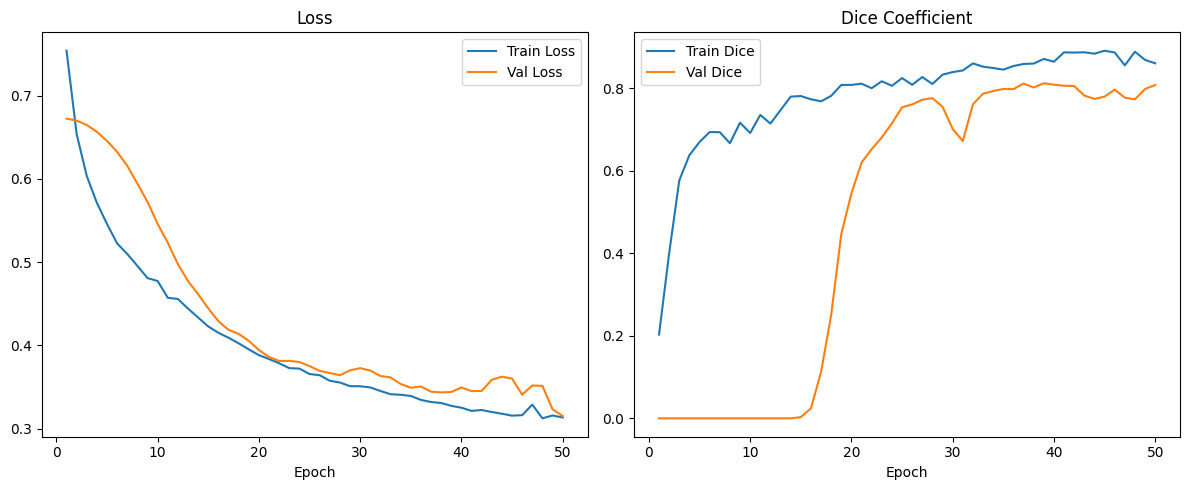

In [ ]:
epochs_range = range(1, epochs+1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, history['train_loss'], label='Train Loss')
plt.plot(epochs_range, history['val_loss'],   label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch'); plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, history['train_dice'], label='Train Dice')
plt.plot(epochs_range, history['val_dice'],   label='Val Dice')
plt.title('Dice Coefficient')
plt.xlabel('Epoch'); plt.legend()

plt.tight_layout(); plt.show()

Visualize a few predictions

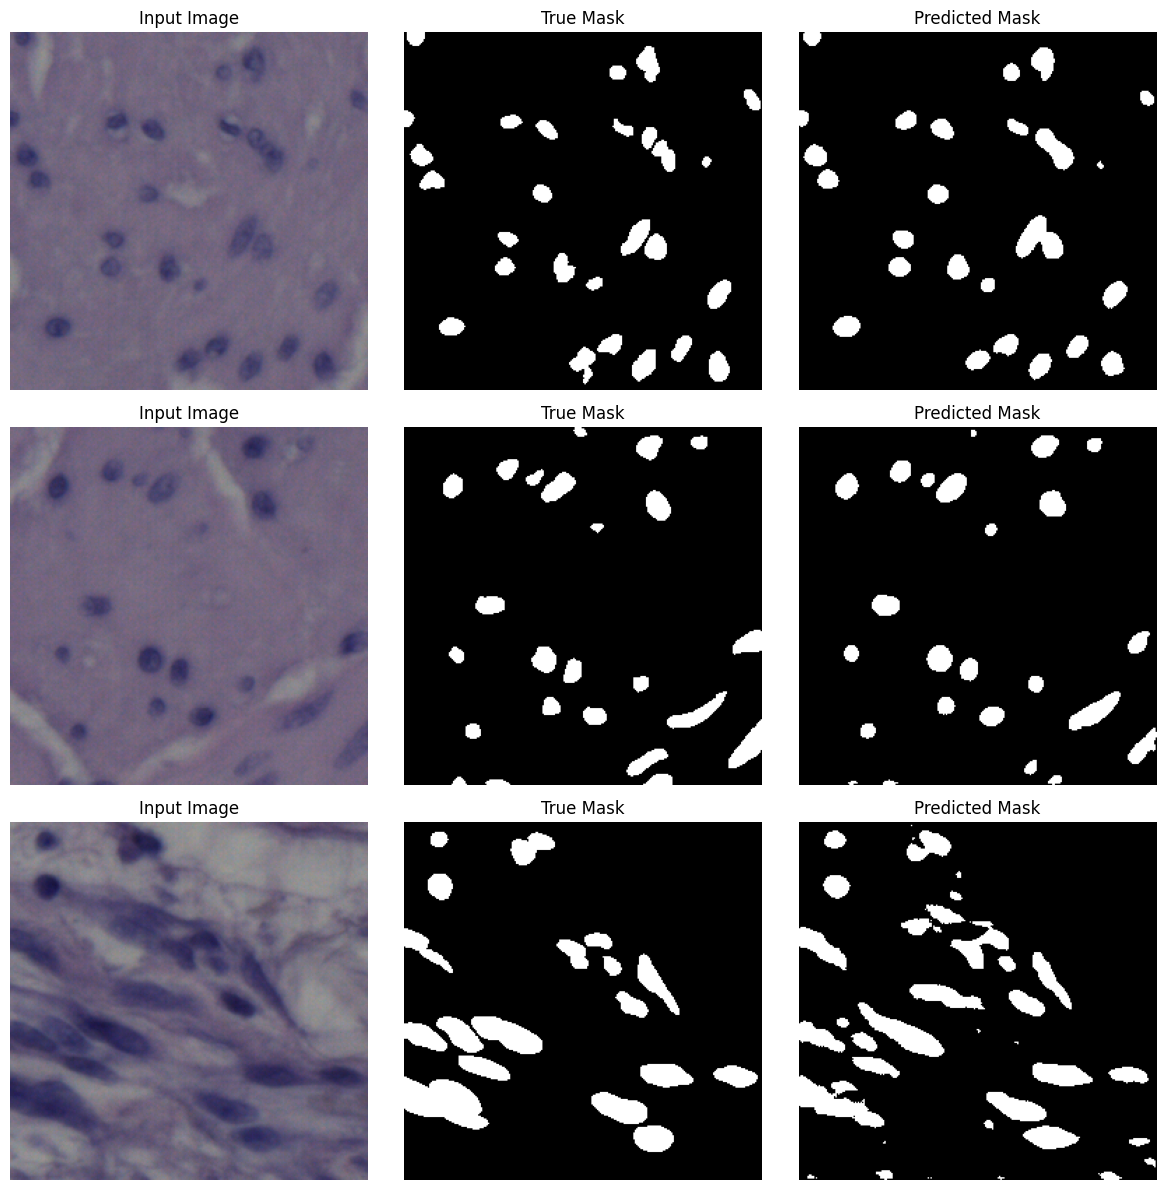

In [ ]:
model.eval()
with torch.no_grad():
    imgs, masks = next(iter(val_loader))       # grab one batch
    imgs = imgs.to(device)
    logits = model(imgs)
    probs = torch.sigmoid(logits).cpu().numpy()
    masks = masks.numpy()

# Number of examples to show
n = 3
fig, axes = plt.subplots(n, 3, figsize=(12, n*4))
for i in range(n):
    img       = imgs[i].permute(1,2,0).cpu().numpy()
    true_mask = masks[i].squeeze()
    pred_mask = (probs[i].squeeze() > 0.5).astype(float)

    axes[i,0].imshow(img)
    axes[i,0].set_title("Input Image")
    axes[i,0].axis("off")

    axes[i,1].imshow(true_mask, cmap="gray")
    axes[i,1].set_title("True Mask")
    axes[i,1].axis("off")

    axes[i,2].imshow(pred_mask, cmap="gray")
    axes[i,2].set_title("Predicted Mask")
    axes[i,2].axis("off")

plt.tight_layout()
plt.show()


Define IoU Metric

In [ ]:
def iou_coeff(preds, targets, eps=1e-6):
    """
    preds, targets: torch.Tensor of shape (B,1,H,W) with 0/1 values
    returns mean IoU over the batch.
    """
    preds_flat = preds.view(preds.size(0), -1)
    targets_flat = targets.view(targets.size(0), -1)
    intersection = (preds_flat * targets_flat).sum(1)
    union = preds_flat.sum(1) + targets_flat.sum(1) - intersection
    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()


Evaluate on Test Set

In [ ]:
# (Here we reuse val_loader as a test set; if you have a separate test split, swap in test_loader)

model.eval()
test_loss = 0.0
test_dice = 0.0
test_iou  = 0.0
with torch.no_grad():
    for imgs, masks in val_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        logits = model(imgs)
        test_loss += criterion(logits, masks).item() * imgs.size(0)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
        test_dice += dice_coeff(preds, masks).item() * imgs.size(0)
        test_iou  += iou_coeff(preds, masks) * imgs.size(0)

n_test = len(val_ds)
print(f"Test Loss: {test_loss/n_test:.4f}")
print(f"Test Dice: {test_dice/n_test:.4f}")
print(f"Test  IoU: {test_iou/n_test:.4f}")


Test Loss: 0.3154
Test Dice: 0.8076
Test  IoU: 0.6960


Threshold Tuning Curve

In [ ]:
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
results = []

model.eval()
with torch.no_grad():
    # collect all logits and masks
    all_logits, all_masks = [], []
    for imgs, masks in val_loader:
        logits = model(imgs.to(device))
        all_logits.append(logits.cpu())
        all_masks.append(masks)
    all_logits = torch.cat(all_logits)
    all_masks  = torch.cat(all_masks)

for thr in thresholds:
    preds = (torch.sigmoid(all_logits) > thr).float()
    d = dice_coeff(preds, all_masks).item()
    j = iou_coeff(preds, all_masks)
    results.append((thr, d, j))

# Display
print(" Thr | Dice   |  IoU")
print("------------------------")
for thr, d, j in results:
    print(f" {thr:.1f} | {d:.4f} | {j:.4f}")


 Thr | Dice   |  IoU
------------------------
 0.3 | 0.6195 | 0.4866
 0.4 | 0.7805 | 0.6709
 0.5 | 0.8076 | 0.6960
 0.6 | 0.7746 | 0.6541
 0.7 | 0.7345 | 0.6029


Error Analysis – Worst-Performing Samples

Worst 5 samples by Dice:
 Sample 002 – Dice: 0.7640
 Sample 001 – Dice: 0.8254
 Sample 000 – Dice: 0.8681


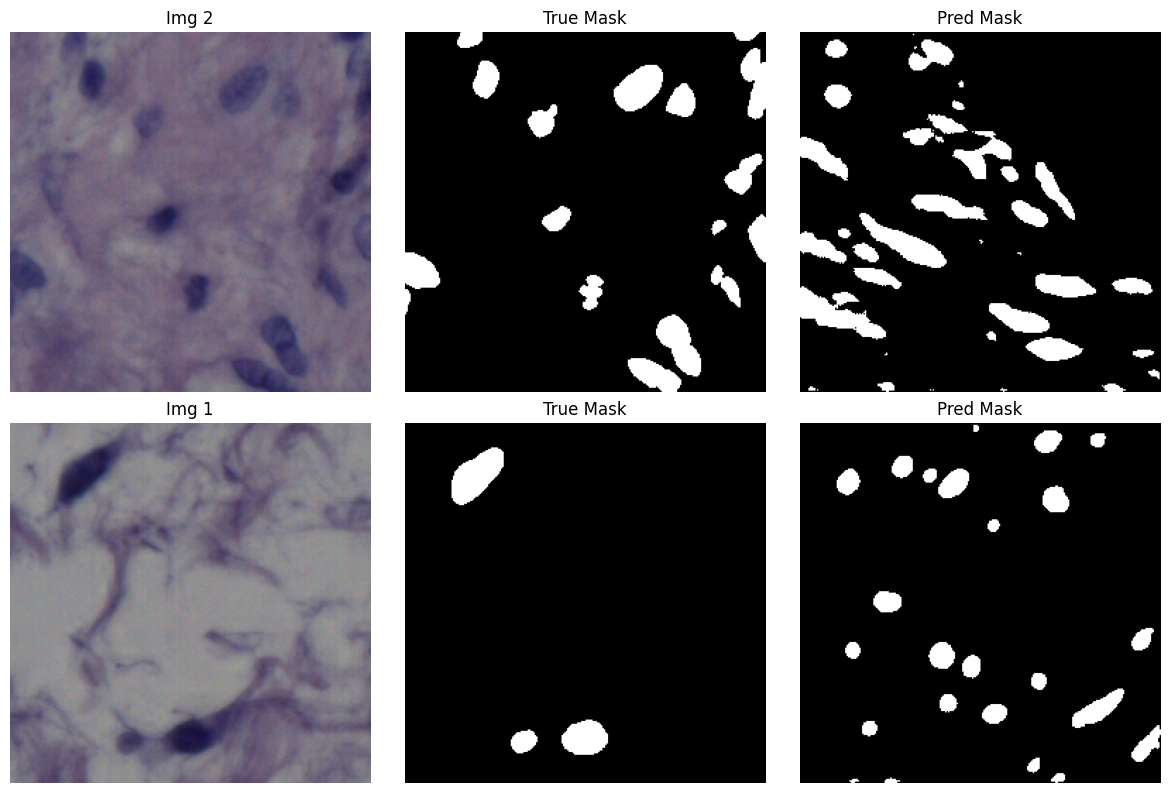

In [ ]:
# Compute per-sample Dice on val set
per_image = []
with torch.no_grad():
    for i in range(len(all_masks)):
        pred = (torch.sigmoid(all_logits[i:i+1]) > 0.5).float()
        true = all_masks[i:i+1]
        per_dice = dice_coeff(pred, true).item()
        per_image.append((i, per_dice))

# Sort and print bottom 5
per_image.sort(key=lambda x: x[1])
print("Worst 5 samples by Dice:")
for idx, d in per_image[:5]:
    print(f" Sample {idx:03d} – Dice: {d:.4f}")


fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for row, (idx, _) in enumerate(per_image[:2]):
    img = X_tensor[idx].permute(1,2,0).numpy()
    true = Y_tensor[idx].squeeze().numpy()
    pred = (torch.sigmoid(all_logits[idx:idx+1])[0].squeeze() > 0.5).numpy()

    axes[row,0].imshow(img); axes[row,0].set_title(f"Img {idx}")
    axes[row,1].imshow(true, cmap='gray'); axes[row,1].set_title("True Mask")
    axes[row,2].imshow(pred, cmap='gray'); axes[row,2].set_title("Pred Mask")

for ax in axes.flatten(): 
    ax.axis('off')
plt.tight_layout()
plt.show()
